<a href="https://colab.research.google.com/github/linh-ktran/technical-test-it4r/blob/main/Avg_rainy_days_rasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create rasters of mean monthly rainy days from  CHIRPS data with Google Earth Engine GEE


# **I. Environment settings**

Install pycrs and update package manager to install earthengine-api:

```
pip install earthengine-api --upgrade
pip install pycrs
```

**Python setup**
You need to authenticate to use the Earth Engine Python and initialize it with a project that you own. This project will be used for running all Earth Engine operations.
```python
import ee
ee.Authenticate()
ee.Initialize(project='ee-linhha53')
```

**To display the results**
```
pip install rasterio
```



# **II. Using Google Earth Engine**

**Method:**
Using Google Earth Engine through Python API to pre-process the rain data to the average number of rainy days per month for the area of interest.

1. Create a ImageCollection with CHIRPS precipitation data.
2. Create a  binary mask for rainy days with the precipitation > 0 mm/day.
3. Calculate the sum of rainy days for a given month in a given year.
4. Calculate the average rainy days for a given month across all years
5. Clip to the area of interest.


In [4]:
import ee
import geemap

# Initialize the library.
ee.Authenticate()
ee.Initialize(project='ee-linhha53')

# Define start and end years, dates (1981 - 2023)
start_year = 1981
end_year = 2023
start_date = ee.Date.fromYMD(start_year, 1, 1);
end_date = ee.Date.fromYMD(end_year, 12, 31);

chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(start_date, end_date)

def create_rainy_mask(image, threshold=0):
    """Function to create a binary rainy day mask.
       Precipitation > 0 mm/day : rainy day
    """
    rainy_mask = image.select(['precipitation']).gt(threshold)
    # Convert the binary mask to integer values (0 or 1)
    #rainy_mask_int = rainy_mask.toInt()
    return image.addBands(rainy_mask.rename('rainy_mask'))

# Map the function over the ImageCollection
rainy_mask = chirps.map(create_rainy_mask).select('rainy_mask')

# Create an ee.List object with a sequence of integer numbers between a start year and an end year
years = ee.List.sequence(start_year, end_year)
# Create an ee.List object with a sequence of integer numbers between 1 and 12 (months)
months = ee.List.sequence(1, 12)


def yearly_monthly_sum(year):
    """Function to map the monthly_sum() to every month in the months sequences."""
    def monthly_sum(month):
        """Function to calculate the sum of rainy days for a given month in a given year."""
        w = rainy_mask.filter(ee.Filter.calendarRange(year, year, 'year')) \
                      .filter(ee.Filter.calendarRange(month, month, 'month')) \
                      .sum()
        return w.set('year', year) \
                .set('month', month) \
                .set('system:time_start', ee.Date.fromYMD(year, month, 1))
    return months.map(monthly_sum)

# Map the yearly_monthly_sum() function to every year in the years sequence to get an ImageCollection with total rainy days in each month in each year
monthly_rainy_days = ee.ImageCollection.fromImages(
    years.map(yearly_monthly_sum).flatten()
)

def monthly_mean(month):
    """Function to calculate the average rainy days for a given month across all years."""
    # Round to the nearest integer.
    w = monthly_rainy_days.filter(ee.Filter.eq('month', month)).mean().round()
    return w.set('month', month) \
            .set('system:time_start', ee.Date.fromYMD(1, month, 1))

# Map the monthly_mean() function to every month in the months sequence and make an ImageCollection from the obtained images
mean_monthly_rainy_days = ee.ImageCollection.fromImages(
    months.map(monthly_mean).flatten()
)

# Add the area of interest
aoi = geemap.shp_to_ee("/content/drive/MyDrive/ENAC-IT4R Technical Test/data/aoi.shp")

def clip_image_collection(image):
    """Function to clip each image to the area of interest shapefile."""
    return image.clip(aoi)

# Map the clip_image_collection() function to the mean_monthly_rainy_days collection
meanMonthlyRainyDays_clipped = mean_monthly_rainy_days.map(clip_image_collection)

# **III. Display the results**

1. Interactive map with `geemap`.
2. Plotting results using Matlotlib.

**1. Interactive map**

The geemap library can be used to display ee.Image objects on an interactive ipyleaflet map.

In [5]:
import calendar
months = list(calendar.month_name)

# Create a geemap.Map() object
Map = geemap.Map()

# Setting parameters for images
vis_params = {'min': 0, 'max': 6, 'palette': ['ffffcc','7eccba', '41b7c4', '2c80b8', '253494', '662A00']}
text_params = {'fontsize': 15, 'bold': True, 'bg_color': 'white', 'position': 'bottomright'}

# Adding each monthly image as a layer
images = meanMonthlyRainyDays_clipped.toList(meanMonthlyRainyDays_clipped.size())
for i in range(12):
  image = ee.Image(images.get(i))
  Map.addLayer(image, vis_params, f"Rainy_days_{months[i+1]}")

# Adding colorbar
Map.add_colorbar_branca(
    colors=vis_params['palette'],
    vmin=vis_params['min'],
    vmax=vis_params['max'],
    categorical=True,
    step=vis_params['max'],
    layer_name="Rainy_days"
    )

Map.add_text(f'Average number of rainy days for {months[i+1]}', **text_params)

# Center the map on the study area
Map.centerObject(aoi)

# Display the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

**2. Visualizing results:**
- Export the raster image to Drive in format Tif File
- Visualizing Tif File Using Matplotlib and GDAL

In [ ]:
# Export the raster image to Drive
import calendar

months = list(calendar.month_name)
images = meanMonthlyRainyDays_clipped.toList(meanMonthlyRainyDays_clipped.size())
for i in range(12):
  image = ee.Image(images.get(i))
  image = image.clip(aoi.geometry()).unmask()
  geemap.ee_export_image_to_drive(
      image,
      description=f'Avg_rainy_days_{months[i+1]}',
      folder='GEE_tif_exports',
      scale=5000,
      region=aoi.geometry()
      )

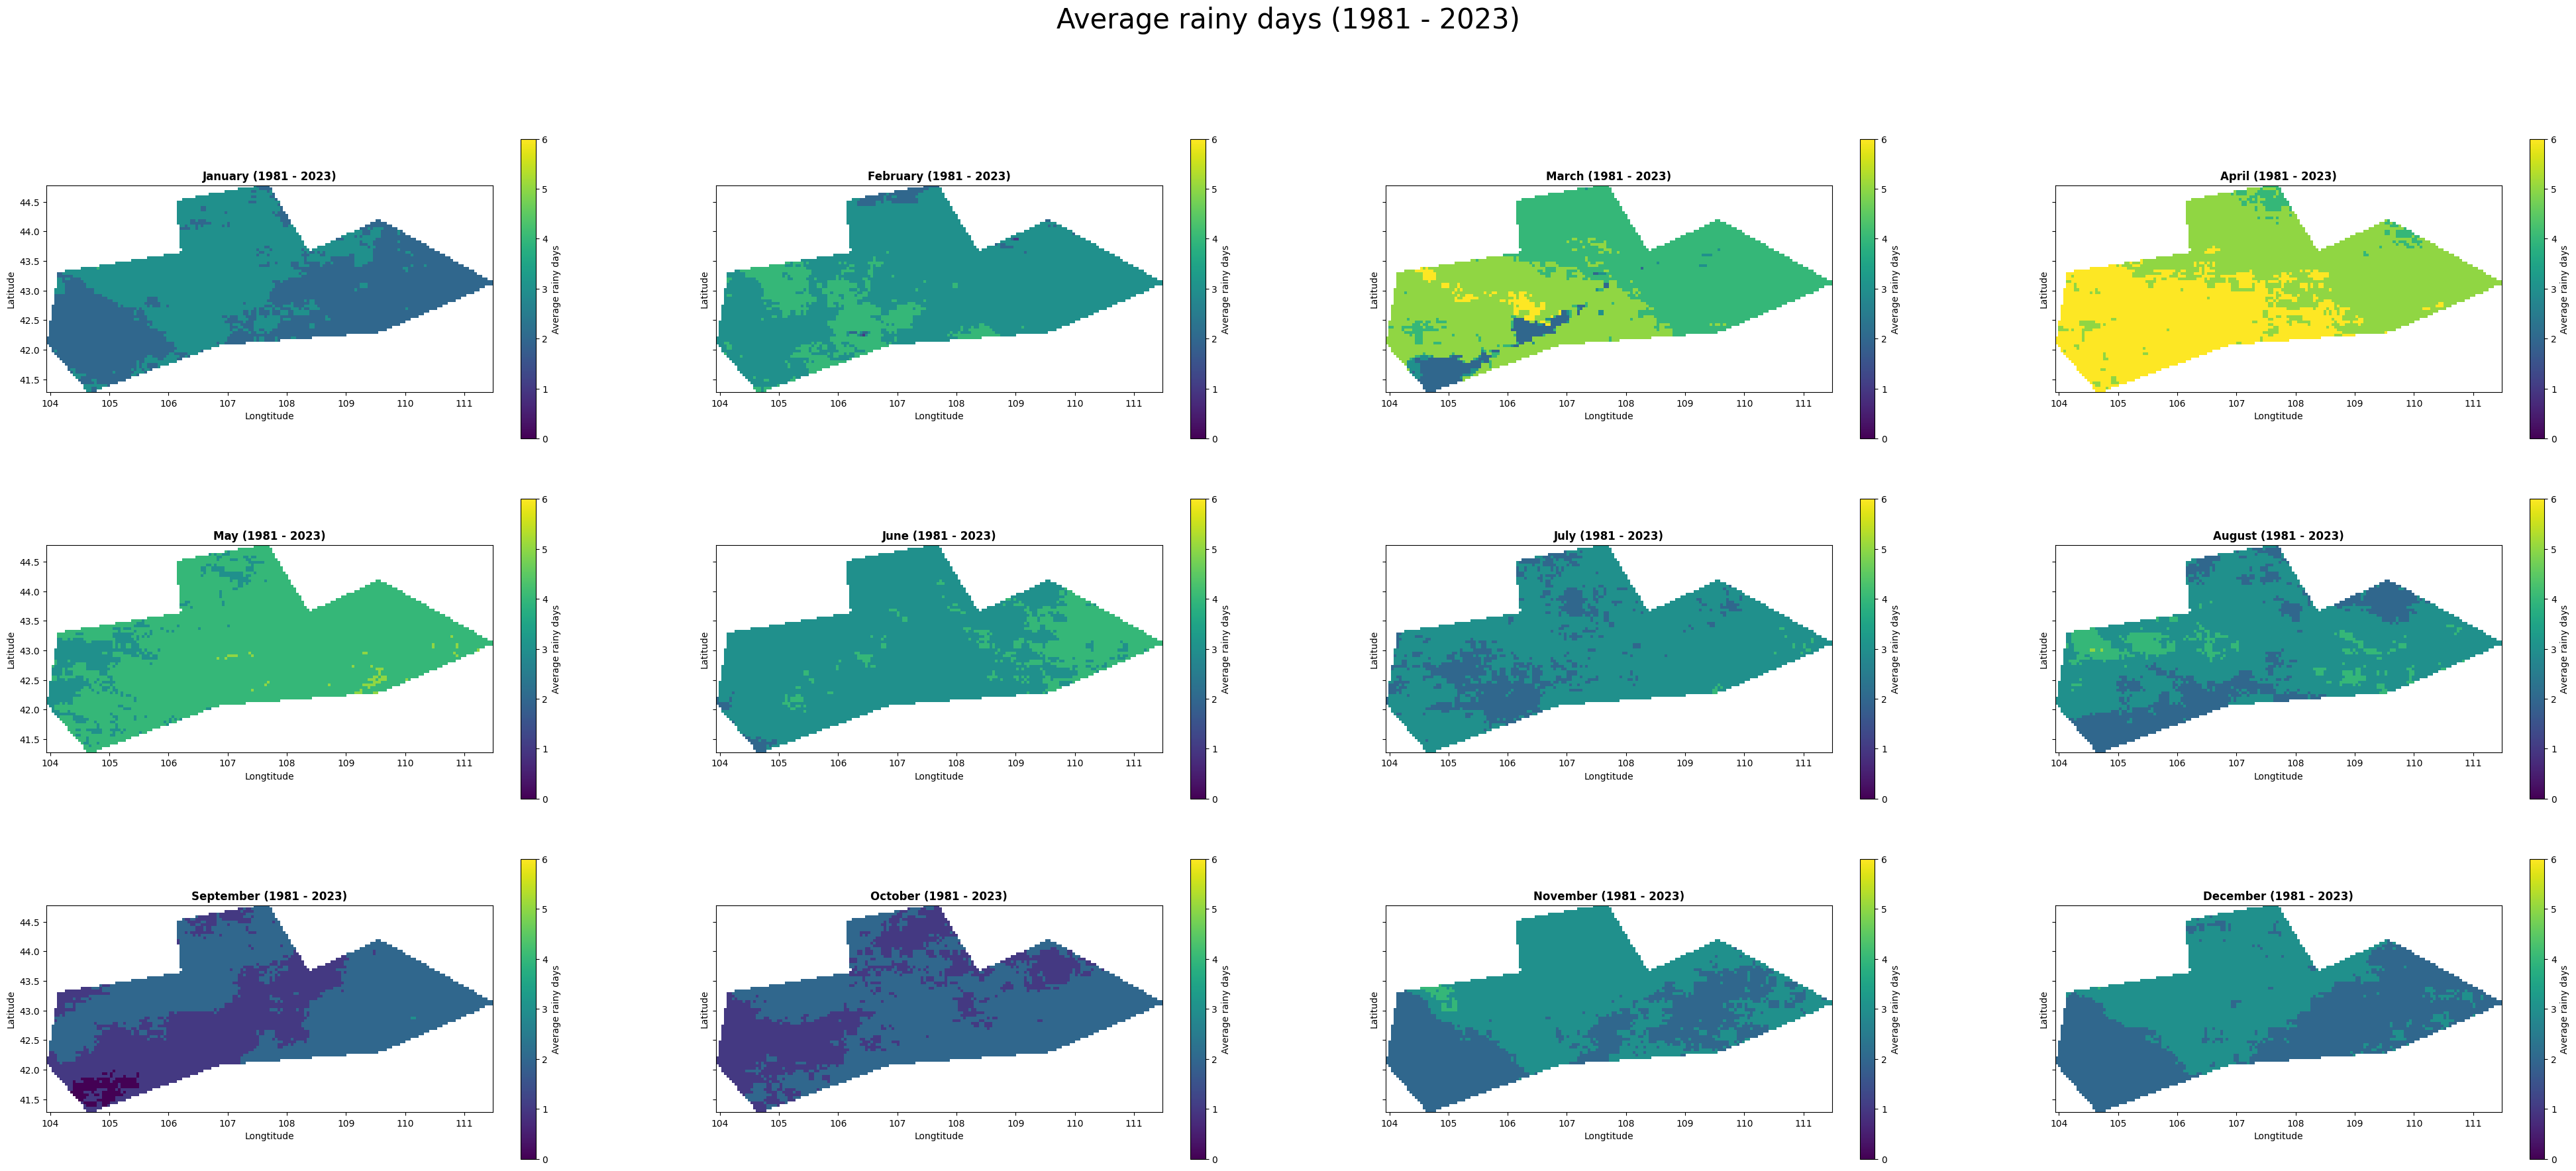

In [8]:
# Visualizing Tif File Using Matplotlib and GDAL
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import calendar
months = list(calendar.month_name)

path = '/content/drive/MyDrive/ENAC-IT4R Technical Test/Solution_LinhTRAN/GEE_tif_exports/Avg_rainy_days_'
cols = 4
rows = 3
fig, ax = plt.subplots(rows, cols, figsize=(50, 20), sharey=True)
fig.suptitle('Average rainy days (1981 - 2023)', fontsize=30)

for i in range(cols*rows):
  ax = plt.subplot(rows,cols,i+1)
  ax.set_xlabel('Longtitude')
  ax.set_ylabel('Latitude')

  path_month = f"{path}{months[i+1]}.tif"
  raster = rasterio.open(path_month, driver="GTiff")

  retted = show(raster, ax=ax, title=f'{months[i+1]} (1981 - 2023)', norm=Normalize(0, 6))

  # Get image to add color bar
  image = retted.get_images()[0]
  fig.colorbar(image, ticks=range(20), label='Average rainy days')

plt.savefig('Avg_rainy_days_12_months.png')

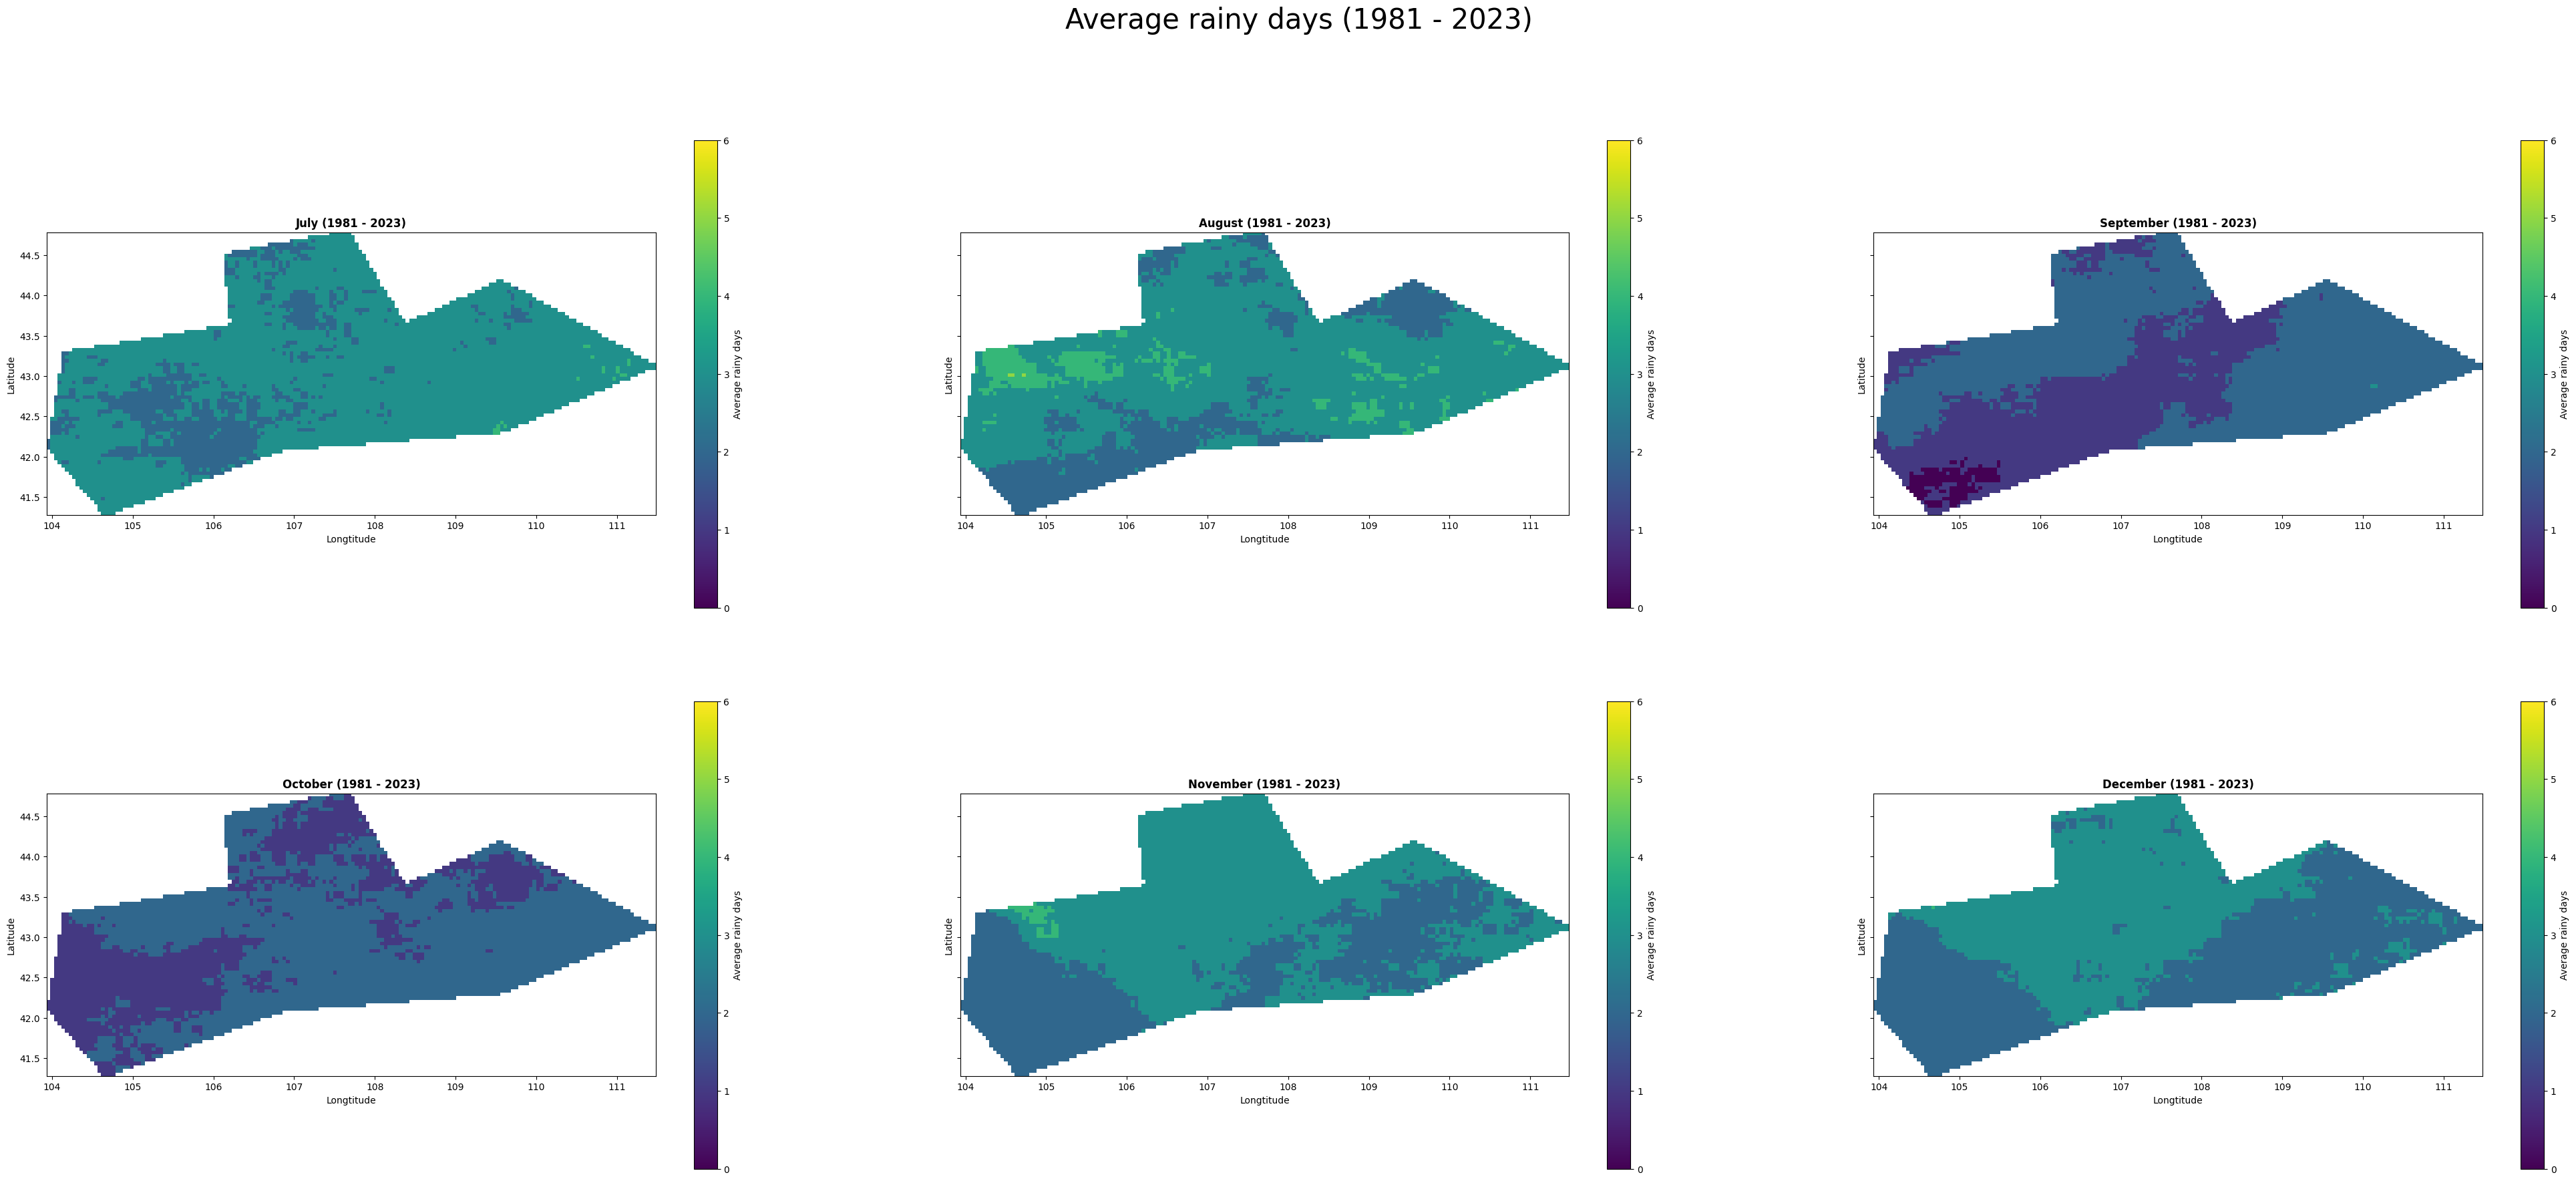

In [9]:
# Visualizing Tif File Using Matplotlib and GDAL
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import calendar
months = list(calendar.month_name)

path = '/content/drive/MyDrive/ENAC-IT4R Technical Test/Solution_LinhTRAN/GEE_tif_exports/Avg_rainy_days_'
cols = 3
rows = 2
fig, ax = plt.subplots(rows, cols, figsize=(50, 20), sharey=True)
fig.suptitle('Average rainy days (1981 - 2023)', fontsize=30)
import itertools

for i, n  in zip(range(6, 12), range(cols*rows)):

  ax = plt.subplot(rows,cols,n+1)
  ax.set_xlabel('Longtitude')
  ax.set_ylabel('Latitude')

  path_month = f"{path}{months[i+1]}.tif"
  raster = rasterio.open(path_month, driver="GTiff")

  retted = show(raster, ax=ax, title=f'{months[i+1]} (1981 - 2023)', norm=Normalize(0, 6))

  # Get image to add color bar
  image = retted.get_images()[0]
  fig.colorbar(image, ticks=range(20), label='Average rainy days')

plt.savefig('Avg_rainy_days_July_to_December.png')